# DM Plan Calculations 
## Dispersion delay across a frequency channel

$$ t_{\text{DM, chan}} \approx 8.3 \, \mu s \, \left( \frac{\text{DM}}{\text{pc cm}^{-3}} \right) \left( \frac{\Delta \nu}{\text{MHz}} \right) \left( \frac{\nu}{\text{GHz}} \right)^{-3} $$

Where:
- \( t_{DM} \) is the dispersion delay across the channel in microseconds (\( \mu s \)) 
- \( DM \) is the dispersion measure in parsecs per cubic centimeter (\( \text{pc cm}^{-3} \))
- \( \Delta \nu \) is the channel bandwidth in megahertz (MHz)
- \( \nu \) is the observing frequency in gigahertz (GHz)

In [11]:
def tCHAN_smear(DM, delta_nu, nu):
    """
    Calculate the dispersion delay across a frequency channel.

    Parameters:
    DM : float
        Dispersion Measure in pc cm^-3
    delta_nu : float
        Channel bandwidth in MHz
    nu : float
        Observing frequency in GHz

    Returns:
    t_DM : float
        Dispersion delay across the channel in microseconds (μs)
    """
    t_DM = 8.3 * DM * delta_nu * (nu ** -3)  # in microseconds
    return t_DM

## Smearing from DM trial step size
$$t_{\mathrm{BW,\,smear}} \approx 8.3 \,\mu\mathrm{s} \,
\left( \tfrac{1}{2} \,\Delta DM_{\mathrm{sub}} \right)
\times \frac{\left( BW / N_{\mathrm{sub}} \right)}{f_{\mathrm{GHz}}^3} $$


In [12]:
def tBW_smear(delta_DM_sub, BW, N_sub, f_GHz):
    """
    Calculate the smearing time due to DM trial step size.

    Parameters:
    delta_DM_sub : float
        DM trial step size in pc cm^-3
    BW : float
        Total bandwidth in MHz
    N_sub : int
        Number of sub-bands
    f_GHz : float
        Observing frequency in GHz

    Returns:
    t_BW_smear : float
        Smearing time in microseconds (μs)
    """
    t_BW_smear = 8.3 * (0.5 * delta_DM_sub) * (BW / N_sub) / (f_GHz ** 3)  # in microseconds
    return t_BW_smear

## Subband DM smearing

$$ t_{\text{subband smear}} \;=\; 8.3~\mu\text{s} \times 
\left(\tfrac{1}{2}\,\Delta \text{DM}_{\text{sub}}\right) 
\times \frac{\tfrac{BW}{N_{\text{sub}}}}{f_{\text{GHz}}^{3}} $$

In [13]:
def tSB_smear(delta_DM_sub, BW, N_sub, f_GHz):
    """
    Calculate the subband DM smearing time.

    Parameters:
    delta_DM_sub : float
        DM trial step size in pc cm^-3
    BW : float
        Total bandwidth in MHz
    N_sub : int
        Number of sub-bands
    f_GHz : float
        Observing frequency in GHz

    Returns:
    t_SB_smear : float
        Subband smearing time in microseconds (μs)
    """
    t_SB_smear = 8.3 * (0.5 * delta_DM_sub) * (BW / N_sub) / (f_GHz ** 3)  # in microseconds
    return t_SB_smear

## Total smearing budget

$$ t_{\text{tot}} \;=\; \sqrt{ \bigl(1000\,dt\bigr)^{2} 
\;+\; t_{\text{chan}}^{2} 
\;+\; t_{\text{subband smear}}^{2} 
\;+\; t_{\text{BW smear}}^{2} }$$

In [14]:
import numpy as np 

def total_smear(dt, t_chan, t_subband_smear, t_BW_smear):
    return np.sqrt((1000*dt)**2 + t_chan**2 + t_subband_smear**2 + t_BW_smear**2)

## Scattering 
$$ \text{log} \; \tau_d = a + b (\text{log DM}) + c (\text{log DM})^2 - \alpha \log \nu $$

In [78]:
def scattering(DM, f_GHz):
    """
    Calculate the scattering time based on DM and observing frequency.

    Parameters:
    DM : float
        Dispersion Measure in pc cm^-3
    f_GHz : float
        Observing frequency in GHz

    Returns:
    t_scatter : float
        Scattering time in microseconds (μs)
    """
    log_t_scatter = -6.46 + 0.154 * np.log10(DM) + 1.07 * (np.log10(DM))**2 - 3.86 * np.log10(f_GHz)
    t_scatter = 10 ** log_t_scatter  # in microseconds
    return t_scatter

# Observational Setup 

In [80]:
'''
Example Header: 

Data file                        : 09_B0329+54.rawspec.0001.fil
Header size (bytes)              : 361
Data size (bytes)                : 70971686912
Data type                        : filterbank (topocentric)
Telescope                        : ???????
Datataking Machine               : ?????
Source Name                      : UNKNOWN
Source RA (J2000)                : 03:32:59.4
Source DEC (J2000)               : +54:34:02.9
Frequency of channel 1 (MHz)     : 109.596859830097102
Channel bandwidth      (MHz)     : 0.024354805066748
Number of channels               : 3296
Number of beams                  : 1
Beam number                      : -1
Time stamp of first sample (MJD) : 60865.334432870368
Gregorian date (YYYY/MM/DD)      : 2025/07/09
Sample time (us)                 : 655.36000
Number of samples                : 5383168
Observation length (minutes)     : 58.8
Number of bits per sample        : 32
Number of IFs                    : 1
'''

dms = np.linspace(0, 800, 100)

fch1 = 109.596859830097102 
foff = 0.024354805066748
nchans = 3296
fctr = fch1 + 0.5*foff*nchans - 0.5*foff
print('Center Frequency (MHz): ', fctr)

dt = 0.00065536 # seconds
BW = nchans * abs(foff)  # MHz
useable_factors = [16, 32, 103, 206, 412, 824]
nsub = 32
blocklen = 2400 # presto default


Center Frequency (MHz):  149.72140117756442


In [98]:
from psrqpy import QueryATNF
from astropy.table import Table

query = QueryATNF(params=['NAME', 'W50', 'W10', 'DM']) # Query the ATNF pulsar catalogue for the following parameters: P0, P1, BINARY, TYPE, P1_I

table = query.table.to_pandas() # The table of ATNF pulsars
# drop W50 values that are NaN
table = table.dropna(subset=['W10'])

W10_mean = np.mean(table['W10'])
W10_1sigma = np.std(table['W10'])

print(f"Mean W10: {W10_mean:.2f} ms"
      f"\n1σ W10: {W10_1sigma:.2f} ms")

Mean W10: 46.26 ms
1σ W10: 67.41 ms


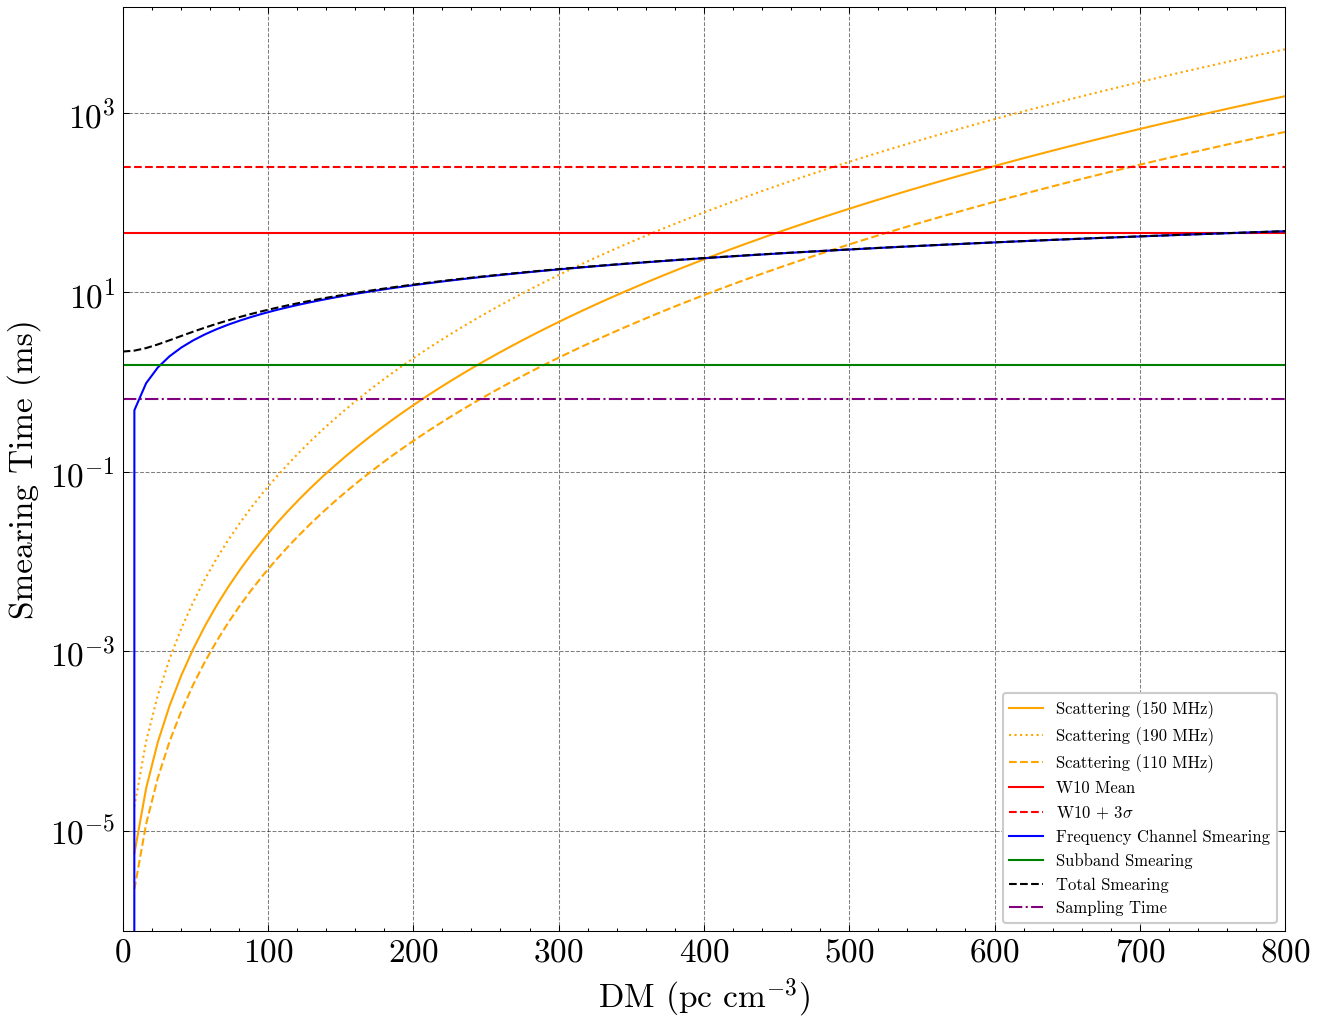

In [ ]:
import matplotlib.pyplot as plt
import scienceplots; plt.style.use(['science', 'no-latex'])

def nearest_value(value, array): 
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

freq_smear = tCHAN_smear(dms, abs(foff), fctr/1000)  # in microseconds
bw_smear = tBW_smear(0.5, BW, nsub, fctr/1000)  # in microseconds
subband_smear = tSB_smear(0.5, BW, nsub, fctr/1000)  # in microseconds
total_smear_time = total_smear(dt, freq_smear, subband_smear, bw_smear)  # in microseconds

# scattering 
scat_dms = np.linspace(0, 800, 100)
scat_ctr = scattering(scat_dms, fctr/1000)  # in microseconds
scat_fch1 = scattering(scat_dms, fch1/1000)  # in microseconds
scat_fchend = scattering(scat_dms, (fch1 + foff*nchans)/1000)  # in microseconds

# convert to ms for plotting
freq_smear /= 1000
bw_smear /= 1000
subband_smear /= 1000
total_smear_time /= 1000

plt.figure(figsize=(10, 8), dpi=150)

for dm_val in np.arange(50, dms.max(), 100):
    closest_DMidx = nearest_value(dm_val, dms)
    yval = total_smear_time[closest_DMidx]

    # print(f"DM={dm_val}, Total Smearing={yval:.5f} ms")
    # plt.vlines(x=dm_val, ymin=plt.ylim()[0], ymax=yval, color='red', alpha=0.3)
    # plt.hlines(y=yval, xmin=0, xmax=dm_val, color='red', alpha=0.3)
    # plt.text(dm_val-10, yval*1.1, f"{yval:.2f} ms", color='red', fontsize=8)
    
plt.plot(scat_dms, scat_ctr/1000, label='Scattering (150 MHz)', color='orange')
plt.plot(scat_dms, scat_fch1/1000, label='Scattering (190 MHz)', color='orange', linestyle='dotted')
plt.plot(scat_dms, scat_fchend/1000, label='Scattering (110 MHz)', color='orange', linestyle='dashed')

# print axhline at W10 mean and + 3 sigma
plt.axhline(y=W10_mean, color='red', linestyle='-', label='W10 Mean')
plt.axhline(y=(W10_mean + 3*W10_1sigma), color='red', linestyle='--', label='W10 + 3$\sigma$')

plt.plot(dms, freq_smear, label='Frequency Channel Smearing', color='blue')
# plt.plot(dms, bw_smear * np.ones_like(dms), label='DM Step Smearing', color='red')
plt.plot(dms, subband_smear * np.ones_like(dms), label='Subband Smearing', color='green')
plt.plot(dms, total_smear_time, label='Total Smearing', color='black', linestyle='--')
plt.axhline(y=dt*1000, color='purple', linestyle='-.', label='Sampling Time')
plt.xlabel('DM (pc cm$^{-3}$)'); plt.xlim(dms[0], dms[-1])
plt.ylabel('Smearing Time (ms)')
plt.yscale('log')
plt.legend(frameon=True, fontsize=8, loc='lower right')

# Optimal DM Step 

$$ \Delta DM \approx \frac{dt}{8.3 \, \mu s} \times \frac{f^3}{\text{BW}_\text{MHz}} $$

Where:

In [46]:
def ddm_single(dt, fctr_MHz, BW_MHz):
    f_GHz = fctr_MHz / 1000.0
    return (dt / 8.3e-6) * (f_GHz**3) / BW_MHz

# Inputs from your header
dt   = 0.00065536        # seconds
fctr = 149.721401        # MHz
BW   = 80.2734375        # MHz

# DM range
loDM = 0
hiDM = 200

# Compute ΔDM
dDM = ddm_single(dt, fctr, BW)

# Compute number of trials
ntrials = int((hiDM - loDM) / dDM)

print(f"Observing frequency: {fctr} MHz")
print(f"Bandwidth: {BW} MHz")
print(f"Sampling time: {dt*1000:.3f} ms")
print(f"DM range: {loDM} to {hiDM} pc cm^-3")
print(f"Optimal ΔDM ≈ {dDM:.3f}")
print(f"Number of DM trials ≈ {ntrials}")


Observing frequency: 149.721401 MHz
Bandwidth: 80.2734375 MHz
Sampling time: 0.655 ms
DM range: 0 to 200 pc cm^-3
Optimal ΔDM ≈ 0.003
Number of DM trials ≈ 60582
